## Waterhackweek cyberseminar
# Workflows for gridded climate datasets
## Diana Gergel and Bart Nijssen
### University of Washington
### February 14, 2019

**Abstract:** Climate change, forecasting, satellite datasets, large model ensembles ... Large gridded datasets are everywhere in hydrology and earth science. While accessing and analyzing these datasets required some serious programming skills not so long ago, a number of toolkits are now available that let you easily access, ingest, analyze and display gridded climate datasets. In this webinar we’ll discuss one of the most common file formats used in our field for large data sets, the Network Common Data Format (NetCDF), and step through a Jupyter notebook to showcase python packages, such as xarray and cartopy, that can be used to examine them. No prior experience required, although we will build on some of the skills you have acquired in earlier webinars in the series.

## GitHub repository

The GitHub repository for this presentation can be found at: https://github.com/bartnijssen/gridded_data

The README.md file in this repository explains how to configure the environment you need to run the sample notebooks.

## Outline

* `gridded_data_1_background.ipynb`


* `gridded_data_2_xarray_and_dask.ipynb`


* `gridded_data_3_cartopy_and_seaborn.ipynb` (this notebook)

    * Creating a heatmap with `seaborn`
    * Creating a global map with features using `cartopy`


* `gridded_data_4_rasterio.ipynb`

Load some packages that we'll be using: 

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import os 
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

__To start with, let's load the DataSet that we left off with in the last notebook:__

In [2]:
tbot = xr.open_mfdataset(os.path.join('data', 
                                      'b.e11*'), concat_dim='time')

 __We're going to start off by looking at using `seaborn` (https://seaborn.pydata.org/), a data visualization library based on matplotlib. It integrates well with `pandas` and can also be used in conjunction with `cartopy`, which we'll talk about in a bit.__ 

__Let's first look at an example from the Seaborn gallery (https://seaborn.pydata.org/examples/index.html), which is a great place to go if you're interested in how you can use `seaborn` in your research.__

<Figure size 576x288 with 0 Axes>

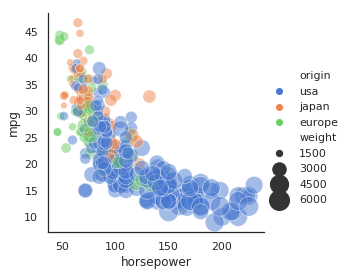

In [4]:
sns.set(style="white")
plt.figure(figsize=(8, 4))

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=4, data=mpg)

__The disadvantage of `seaborn` is that to use this code, our DataFrame needs to be structured pretty similar to this one:__

In [5]:
mpg[:5]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


__Let's take a look at another example, and this time let's get our data to be in the right format:__

__We're taking this example heatmap from the Seaborn gallery:__

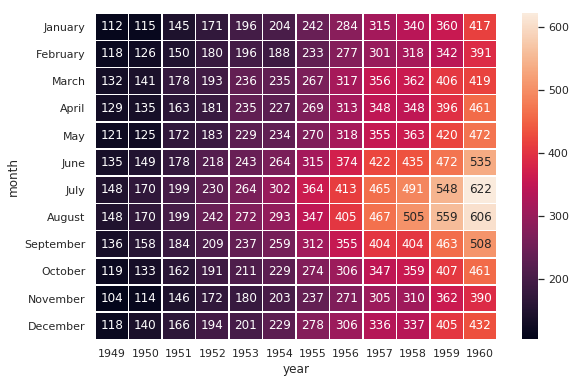

In [6]:
sns.set()

# Load the example flights dataset and conver to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

__We'll start off with selecting one spatial point from our DataSet, this is located in the southern part of South America__: 

__And before we do that we'll subset our DataSet on the time axis:__

In [7]:
tbot_time_slice = tbot['TBOT'].sel(time=slice('2070-01-01', '2099-12-31'))

In [8]:
tbot_pt = tbot_time_slice[:, 45, 233]

__Now we've lost our spatial dimension and just have a time series:__

In [9]:
tbot_pt

<xarray.DataArray 'TBOT' (time: 360)>
dask.array<shape=(360,), dtype=float32, chunksize=(360,)>
Coordinates:
    lat      float32 -47.59162
    lon      float32 291.25
  * time     (time) object 2070-01-01 00:00:00 ... 2099-12-01 00:00:00
Attributes:
    long_name:     atmospheric air temperature
    units:         K
    cell_methods:  time: mean

__We need our DataFrame to be formatted similarly to the example one:__

In [10]:
flights_long[:5]

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


__So let's create our DataFrame with the subsetted `TBOT`:__

In [11]:
tbot_df = pd.DataFrame()
tbot_df['year'] = tbot_time_slice['time.year'].values
tbot_df['month'] = tbot_time_slice['time.month'].values
tbot_df['tbot'] = (tbot_pt - 273.15).values

__And let's see what it looks like:__

In [12]:
tbot_df[:5]

,year,month,tbot
0,2070,1,9.816559
1,2070,2,15.533783
2,2070,3,13.611511
3,2070,4,9.820679
4,2070,5,10.043091


__Now let's make our heatmap:__

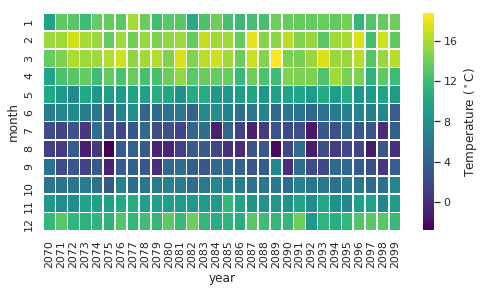

In [13]:
sns.set()

f, ax = plt.subplots(figsize=(8,4))
tbot_pivot = tbot_df.pivot("month", "year", "tbot")
sns.heatmap(tbot_pivot, 
            linewidths=.5, 
            ax=ax, 
            cbar_kws={'label': 'Temperature ($^\circ$C)'}, 
            cmap='viridis')

__Now we'll shift to a quick intro to `cartopy` (https://scitools.org.uk/cartopy/docs/latest/), a package designed for geospatial data processing to produce maps and other analyses.__

__We'll start by visualizing the mean for the last 30 years of the 21st century:__

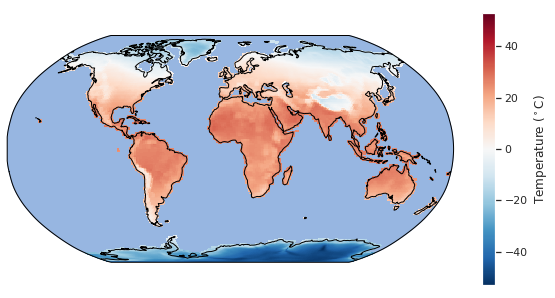

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines()

(tbot_time_slice.mean('time') - 273.15).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                             subplot_kws={'projection': ccrs.Robinson()}, 
                                             cbar_kwargs={'label': 'Temperature ($^\circ$C)'})
ax.add_feature(cfeature.OCEAN)

__We can add some country borders too:__

/pool0/data/nijssen/.conda/whw_gridded_data/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


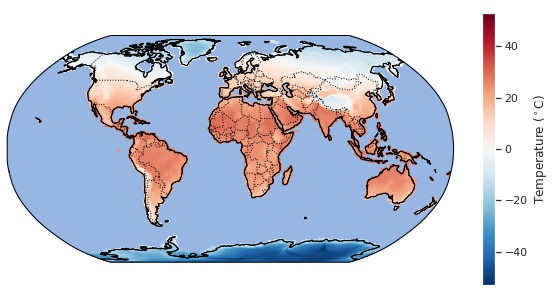

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines()

(tbot_time_slice.mean('time') - 273.15).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                             subplot_kws={'projection': ccrs.Robinson()}, 
                                             cbar_kwargs={'label': 'Temperature ($^\circ$C)'})
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

__And then also lakes and rivers:__

/pool0/data/nijssen/.conda/whw_gridded_data/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/pool0/data/nijssen/.conda/whw_gridded_data/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


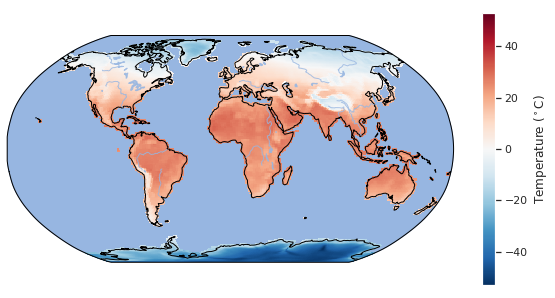

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines()

(tbot_time_slice.mean('time') - 273.15).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                             subplot_kws={'projection': ccrs.Robinson()}, 
                                             cbar_kwargs={'label': 'Temperature ($^\circ$C)'})
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.8)
ax.add_feature(cfeature.RIVERS, alpha=0.8)

__There are lots of other projections available too: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#cartopy-projections__

__We can also define our own classes of projections, which I've done for the Arctic for my research.__

__If you'd like to learn more about `cartopy`, the `cartopy` site is a great place to explore: https://scitools.org.uk/cartopy/docs/latest/index.html__